![CC](https://i.creativecommons.org/l/by/3.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 3.0 International License](http://creativecommons.org/licenses/by/3.0/).

# Contents
1. Introduction and structure of this repository  
2. Active flow control and the numerical setup  
    2.1 Active flow control and the general flow problem   
    2.2 Numerical setup  
3. Choosing parameters for a model-free (MF) training 
4. Choosing parameters for a model-based (MB) training using the 'env_model_rotating_cylinder.py' script (**depreciated**)   
    4.1. Limitiations with respect to the trajectory length  
    4.2. Differences between running a training on an HPC cluster and on a local machine  
5. Choosing parameters for a model-based (MB) training using the 'env_model_rotating_cylinder_new_training.py' script   
    5.1 Influence of the number of models  
    5.2 Running an MB-training on different HPC systems
6. Final results for trainings with $Re = 100$  
7. Final results for trainings with $Re = 2000$  
8. Concluding remarks

# 1. About this repository
This student thesis project aims to implement a model-based deep reinforcement learning (MB-DRL) algorithm for controlling the flow past a cylinder. The [drlfoam](https://github.com/OFDataCommittee/drlfoam) repository, which already provides a model-free version (MF-DRL) is herefore used as a starting point. A complete documentation of the work done in this project can be found in the [report](https://github.com/JanisGeise/robust_MB_DRL_for_flow_control) section of the *Readme* file, as well as the references used (it is also recommended to check out the [references](https://github.com/JanisGeise/robust_MB_DRL_for_flow_control) section at the bottom of the *Readme* file). The following notebook will give a brief summary of this report as well as an introduction about how to use this repository. In case contents of this notebook are not rendered correctly on Github, e.g. tables, please download and open this notebook locally using `jupyter-lab`. <br><br>
This repository contains three main directories:
- *mb_drl*:
    - The *mb_drl* directory contains all altered and added scripts of *drlfoam* in order to modify the MF-DRL algorithm towards an MB-version. These scripts can e.g. be downloaded and pasted into an existing (local) *drlfoam* version. Alternatively, a full MB-version of the *drlfoam* repository can be found [here](https://github.com/JanisGeise/drlfoam), which was forked from the [original drlfoam](https://github.com/OFDataCommittee/drlfoam) repository. <br><br>
- *test_env_models*:
    - The *test_env_models* directory provides scripts to test different ways of training- and testing environment models on the data generated by the (original) model-free DRL-algorithm. Prior using these scripts, a model-free training needs to be executed. Suggestions and advises on how to efficiently run a model-free training in drlfoam will be discussed in [section 3](#MF_training). Once the training data is generated, the *train_environment_model.py* script can be used to test the following configurations:
        - train one global environment model for all the training data without taking the episode number into account    
        - train one environment model for predicting $c_l$ and $p_i$ and another model for predicting $c_d$. These models are also trained on all the data available, despite considering the episode in which the data was generated
        - the same as the two aforementioned options, but this time the environment model (or models) are trained for each new episode. This means two consecutive episodes are taken for training the models(s), then these model(s) are used to predict the next episode
        - these four options are covering therefore all extrema, namely having either one model performing averagly over all episodes or highly specialized models performing well, but only for the specific episode they are trained for. In reality, one would now make a compromise between these two extrema, as it is done in the current implementation of the MB-DRL algorithm
        - an option for training the environment models with low-passed filtered trajectories for $c_d$, this has found to have only little effect on the results
        - options for fine-tuning the models, such as the number of time steps used as input, number of hidden layers, number of neurons and length of the trajectories
        - an option to predict the change of state rather than predicting the next state. This option produces complete unrealistic results for the trajectories of $c_l$ and $p_i$ and is therefore not recommended to use
        - the following table sums up the available options, which can be set in the *setup* dict of the *train_environment_model.py* script:  
        | option         |                     description                         | default / recommended value |  
        | ---            |                         ---                             |               ---           |  
        | load_path      | path to the training data generated with MF-DRL         | ../drlfoam/examples/test_training/ |  
        | path_to_probes | path to the location of the probe data, this normally should be the same for all cases | base/postProcessing/probes/0/ |  
        | model_dir      | directory where to run the script                       | test_env_models/ |  
        | episode_depending_model | either one global model for whole data set or a new model / new models is trained for each episode, based on the previous two episodes | False |  
        | two_env_models | if *True*: one model only for predicting $c_d$, another for $p_i$ and $c_l$; *False*: only one model for all three parameters                   | True  |  
        | print_temp     | print core temperatur of processor as info                                            | False |  
        | normalize      | if *True*: data will be normalized to interval of [1, 0] for training and predictions | True  |  
        | smooth_cd      | flag if $c_d$-trajectories should be filtered after loading (low-pass filter)         | False |  
        | predict_ds     | predict the change of state, not the next state itself                                | False |  
        | n_input_steps  | initial time steps as input for the environment models, is required to be $n_t \gt 1$        | 30 |  
        | len_trajectory | trajectory length for training the environment model, this option can be set independently of the trajectory length used in MF-DRL for creating the data. <br>The only prerequisite is, that *len_trajectory* $\%$ *length_trajectory(MF-DRL)* $== 0$                              | 200 |  
        | ratio          | splitting ratio for train-, validation and test data. For episode-wise models, the test data ratio needs to be set to zero since the each next episode is used as test data                                                                                                | (0.65, 0.3, 0.05) <br> (0.65, 0.35, 0.0)|  
        | epochs         | number of epochs to run for the environment model, if *two_env_models* then this refers to the model for $c_l$ and $p_i$        | 10 000 |  
        | n_neurons      | number of neurons per layer for the environment model, if *two_env_models* then this refers to the model for $c_l$ and $p_i$    | 50 |
        | n_layers       | number of hidden layers for the environment model, if *two_env_models* then this refers to the model for $c_l$ and $p_i$        | 3 |  
        | n_neurons_cd   | number of neurons per layer for the environment model for cd (if option *two_env_models* is set to *True*) | 50 |  
        | n_layers_cd    | number of hidden layers for the environment model for cd (if option *two_env_models* is set to *True*)     | 5 |  
        | epochs_cd      | number of epochs to run for the environment model for cd (if option *two_env_models* is set to *True*)     | 10 000 |  
        <br> 
    - Further, within this directory are scripts to post-process and visualize all results and data created, as well as conducting parameter studies with respect to the influence of the model architecture or number of time steps as input.<br> <br> 
- *scripts_py_plots*:
    - this directory provides scripts for post-processing all results generated over the course of the training (MB-DRL as well as MF-DRL)
    - various scripts for conducting parameter studies and visualizing data of these parameter studies, e.g. investigating the influence of the buffer size and trajectory length as shown in [section 3](#MF_training)

# 2. Active flow control and numerical setup
This section briefly discusses the general flow problem to solve and the numerical setup. As the name suggests, *drlfoam* uses the open-source CFD software [OpenFOAM](https://www.openfoam.com/), currently in the version *v2206*.

## 2.1 General flow problem
The *drlfoam* package aimes to control the flow past a cylinder using deep-reinforcement learning (DRL). The flow is unsteady and incompressible, the default Reynolds number is set to $Re = 100$. As depiced in the following figures, without flow control vortex shedding, formally known as Kármán vortex street, developes. During training, the agent tries to learn a control law by rotating the cylinder with the goal to minimize $c_l$ and $c_d$, hereby the angular velocity $\omega$ is bound by the interval $\omega \in [-5, 5]$. A comparison of the uncontrolled flow past a cylinder with the controlled flow, both at a Reynolds number of $Re = 100$, illustrates the effect of active flow control:
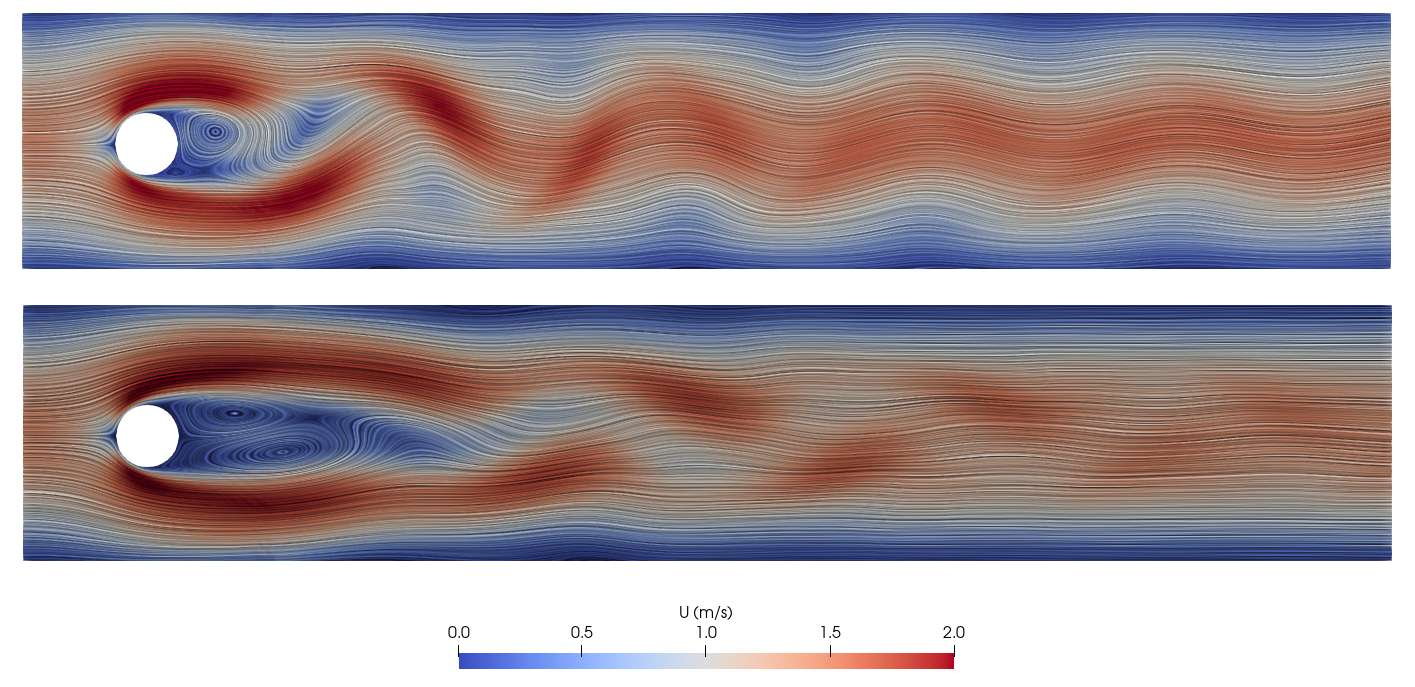

The upper figure shows the uncontrolled flow while in the lower figure active flow control was applied. Clearly it can be seen that by rotating the cylinder in an optimal way, the vortex shedding can be reduced significantly.

## 2.2 Numerical setup
The described flow problem is unsteady, therefore the transient, incompressible solver [pimpleFoam](https://www.openfoam.com/documentation/guides/latest/doc/guide-applications-solvers-incompressible-pimpleFoam.html) is used. The cylinder has a default diameter of  $d = 0.1m$, the free stream velocity is $U_{\infty} = 1 m/s$. During the simulation, $c_l$ and $c_d$ at the cylinder surface are written out as well as pressure values $p_i$ at defined positions within the flow field. In the default setup, the number of probes is set to $12$, which are all placed in the wake of the cylinder as depicted in the following plot:
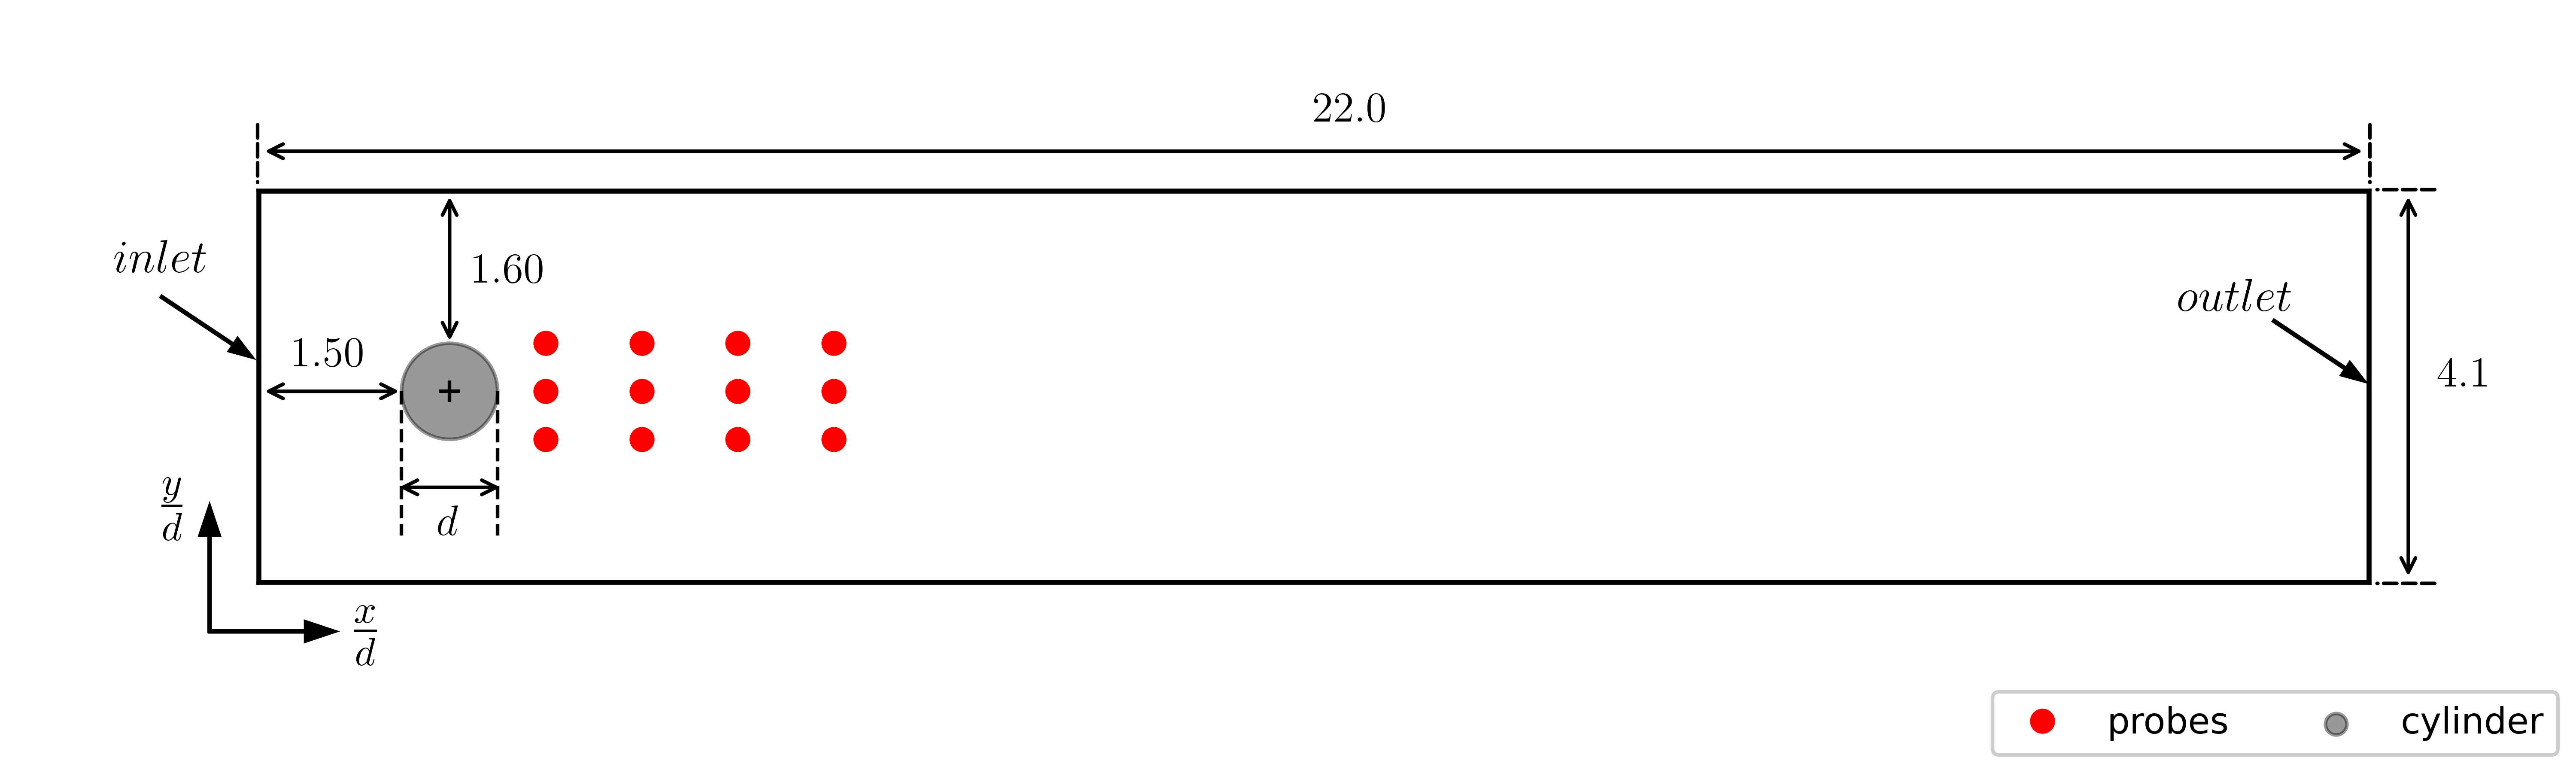

However, the number of probes can be altered in the *controlDict* within the *openfoam* directory of *drlfoam*. An example file containing additional $12$ probes in the vicinity of the cylinder can be found in the [controlDict_additional_probe_locations](https://github.com/JanisGeise/robust_MB_DRL_for_flow_control/blob/main/controlDict_additional_probe_locations) file.  

**Note:** in all the scripts, e.g. for post-processing, the pressure values at the probe locations are usually refered to as *states*, since these values are used at input into the policy network.

# 3. Choosing optimal parameters for a model-free training (MF-DRL) <a id="MF_training"></a>
When running a model-free training, there are mainly three parameters which control the outcome of the training. The first parameter is the buffer size, determining how many trajectories should be generated within each episode, this parameter is named *-b* in the *run_training.py* script. The second parameter is the length of the trajectory *-f*. It is important to note that the first $4s$ are uncontrolled (base case), therefore, the length of the trajectory (in the following *l* ) is always $l = f - 4s$ with $f$ denoting the parameter *f*  in the *run_training.py* script. Lastly, the number of episodes to run (parameter *-i* ) can be defined. The number of runners *-r* defines the number of parallel executions and should ideally be set equal to the buffer size (provided the hardware is not restricting the number of parallel processes). <br><br>
The setup for a model-free training is highly depending on the available resources. On a cluster like the [HPC](https://www.tu-braunschweig.de/it/dienste/21/phoenix) of TU Braunschweig, the buffer size is recommended to be set to $b=10$ and the trajectory length to $l=6s$ ($\equiv f=10$). The training should then converge after around $i = 80$ episodes and approximately $9$ hours. When running a training on a local machine, this setup is not feasible to run in a realisitc amount of time, however, a buffer size of $b=8$, trajectory length of $l=2s$ ($\equiv f=4$) can be run on an *Intel <sup>R</sup> Core<sup>TM</sup> i7-11800H* with $8$ cores in about *23h:19min* (also for $i = 80$ episodes and averaged over 3 different seeds). <br><br>
The following plots shall give an overview on how the performance is affected by the aforementioned parameters. To make the results independent of the available computational resources, all data are scaled to an interval of $[0, 1]$ using a min-max scaling. Consequently, changes within parameters are to be interpreted relative to each other. The reward function is defined as $r(c_d, c_l) = 3 - (c_d + 0.1 * | c_l |)$ with $r$ denoting the *reward* and therefore a measure of the performance of the agent over the course of the training. The computational costs on the other hand are taken into account by the required run time *t*.  In the following figures, $\mu$ refers to the mean values averaged over three different seeds and all episodes, while $\sigma$ denotes the corresponding standard deviation. All cases are run for $80$ episodes, ensuring the comparability when using the rewards averaged over all episodes.<br><br>
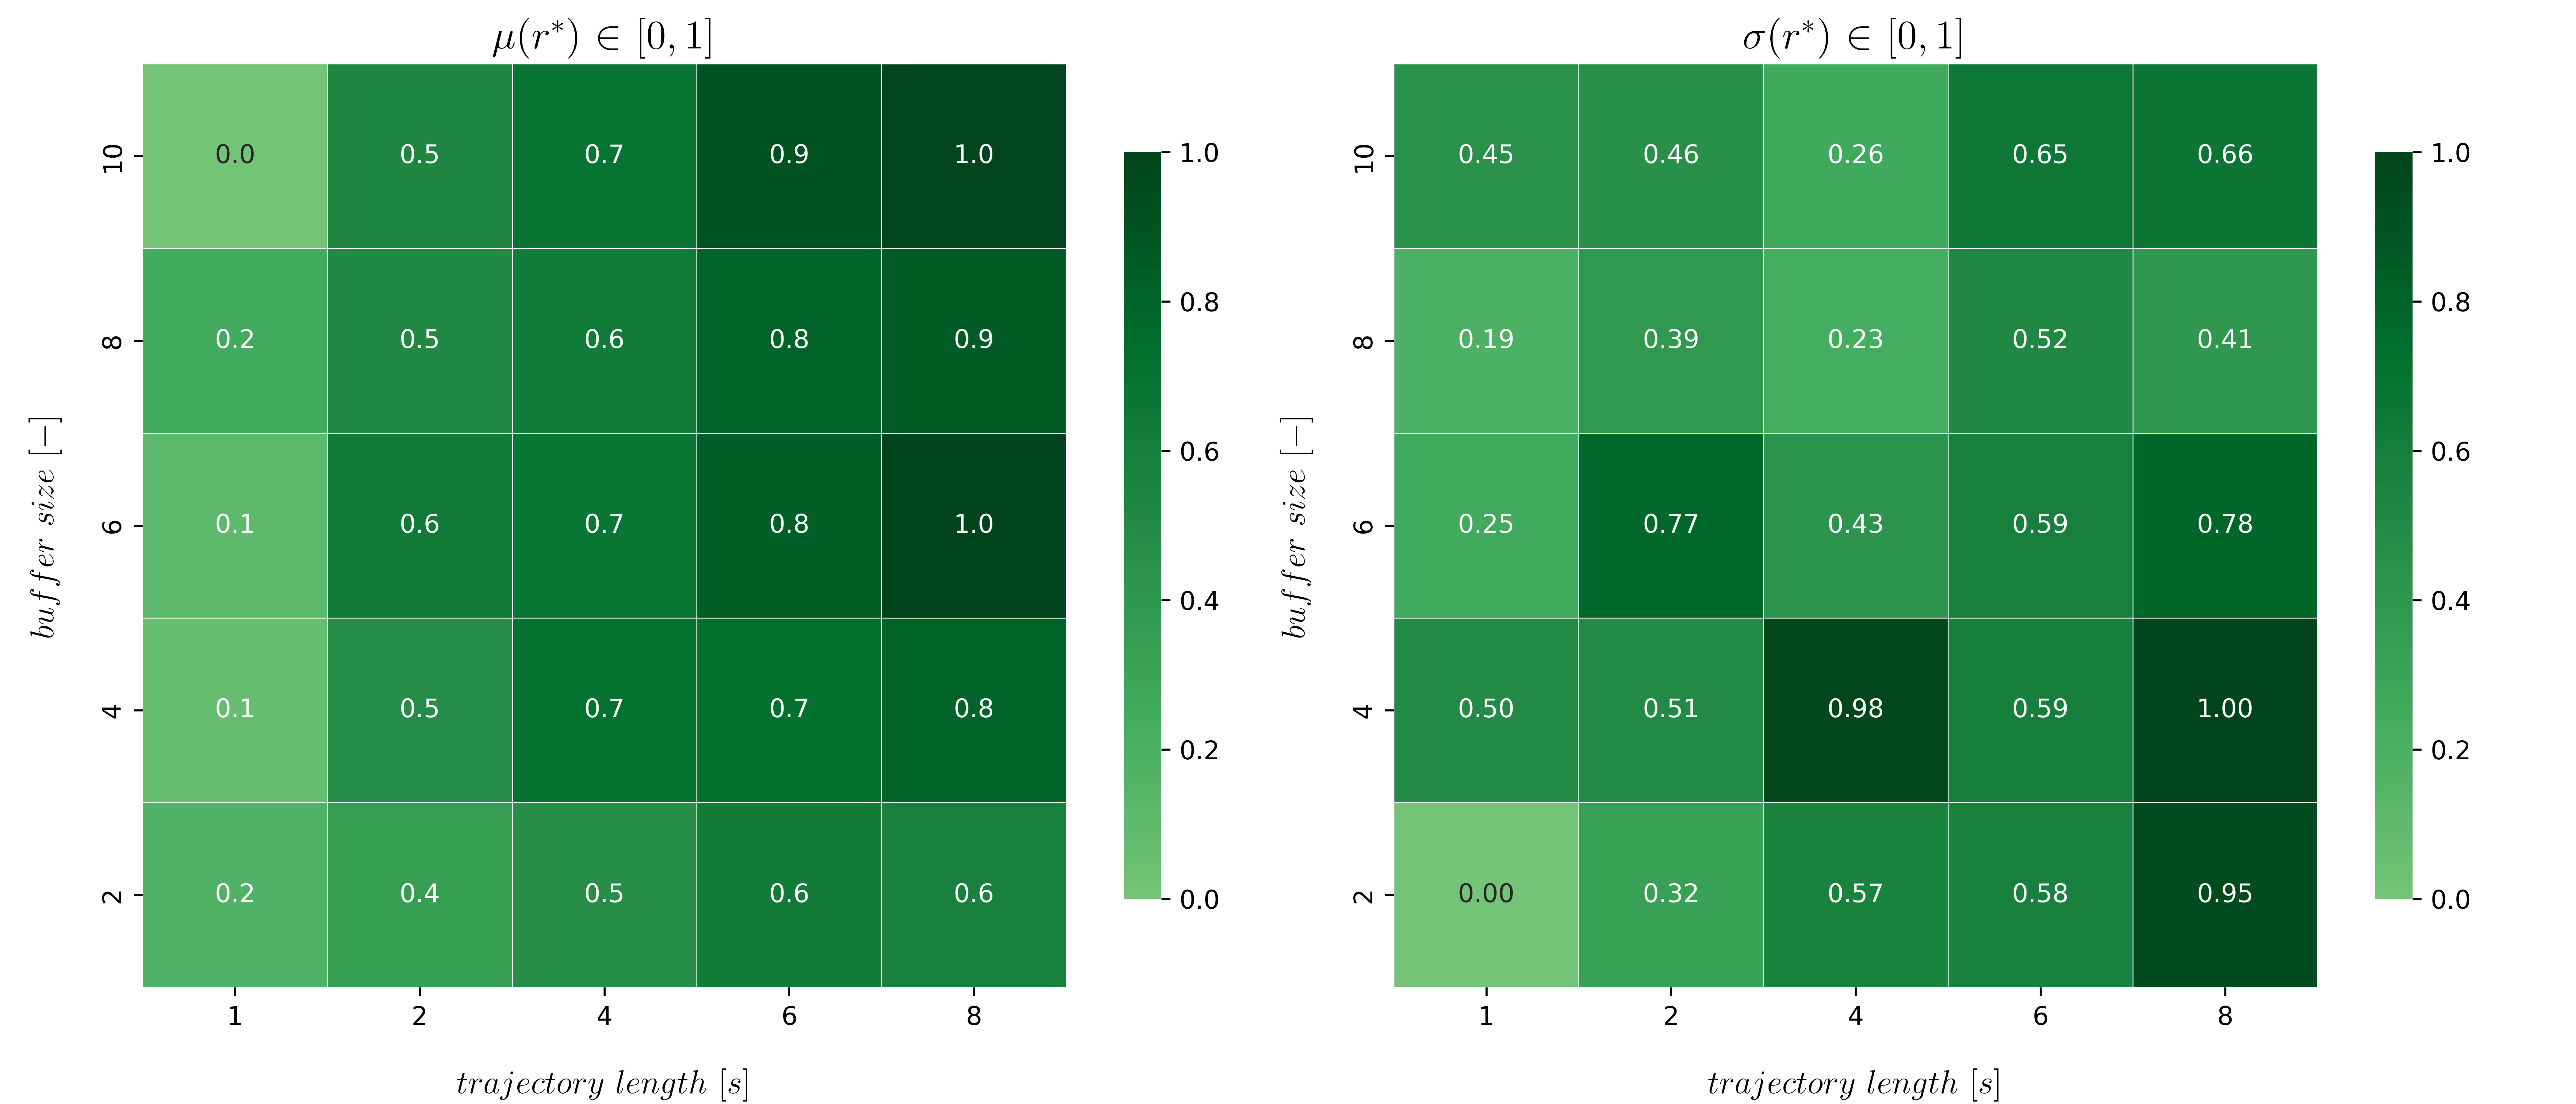
<br><br>
The buffer size has only little effect, as can be seen by the rewards. Therefore, it is recommended to reduce the buffer size in favour of an increased trajectory length if the computational resources are a limiting factor. The runtime, however, increases significantly when increasing the trajectory length from $l=6s$ to $l=8s$. Trajectory lengths of $l \ge 8s$ have no siginificant effect on the resulting performance leading mainly to an increase of the run times. Further, running a training for more than $80$ episodes may improve the results in some cases but in general the training should converge after $80$ episodes.<br><br>
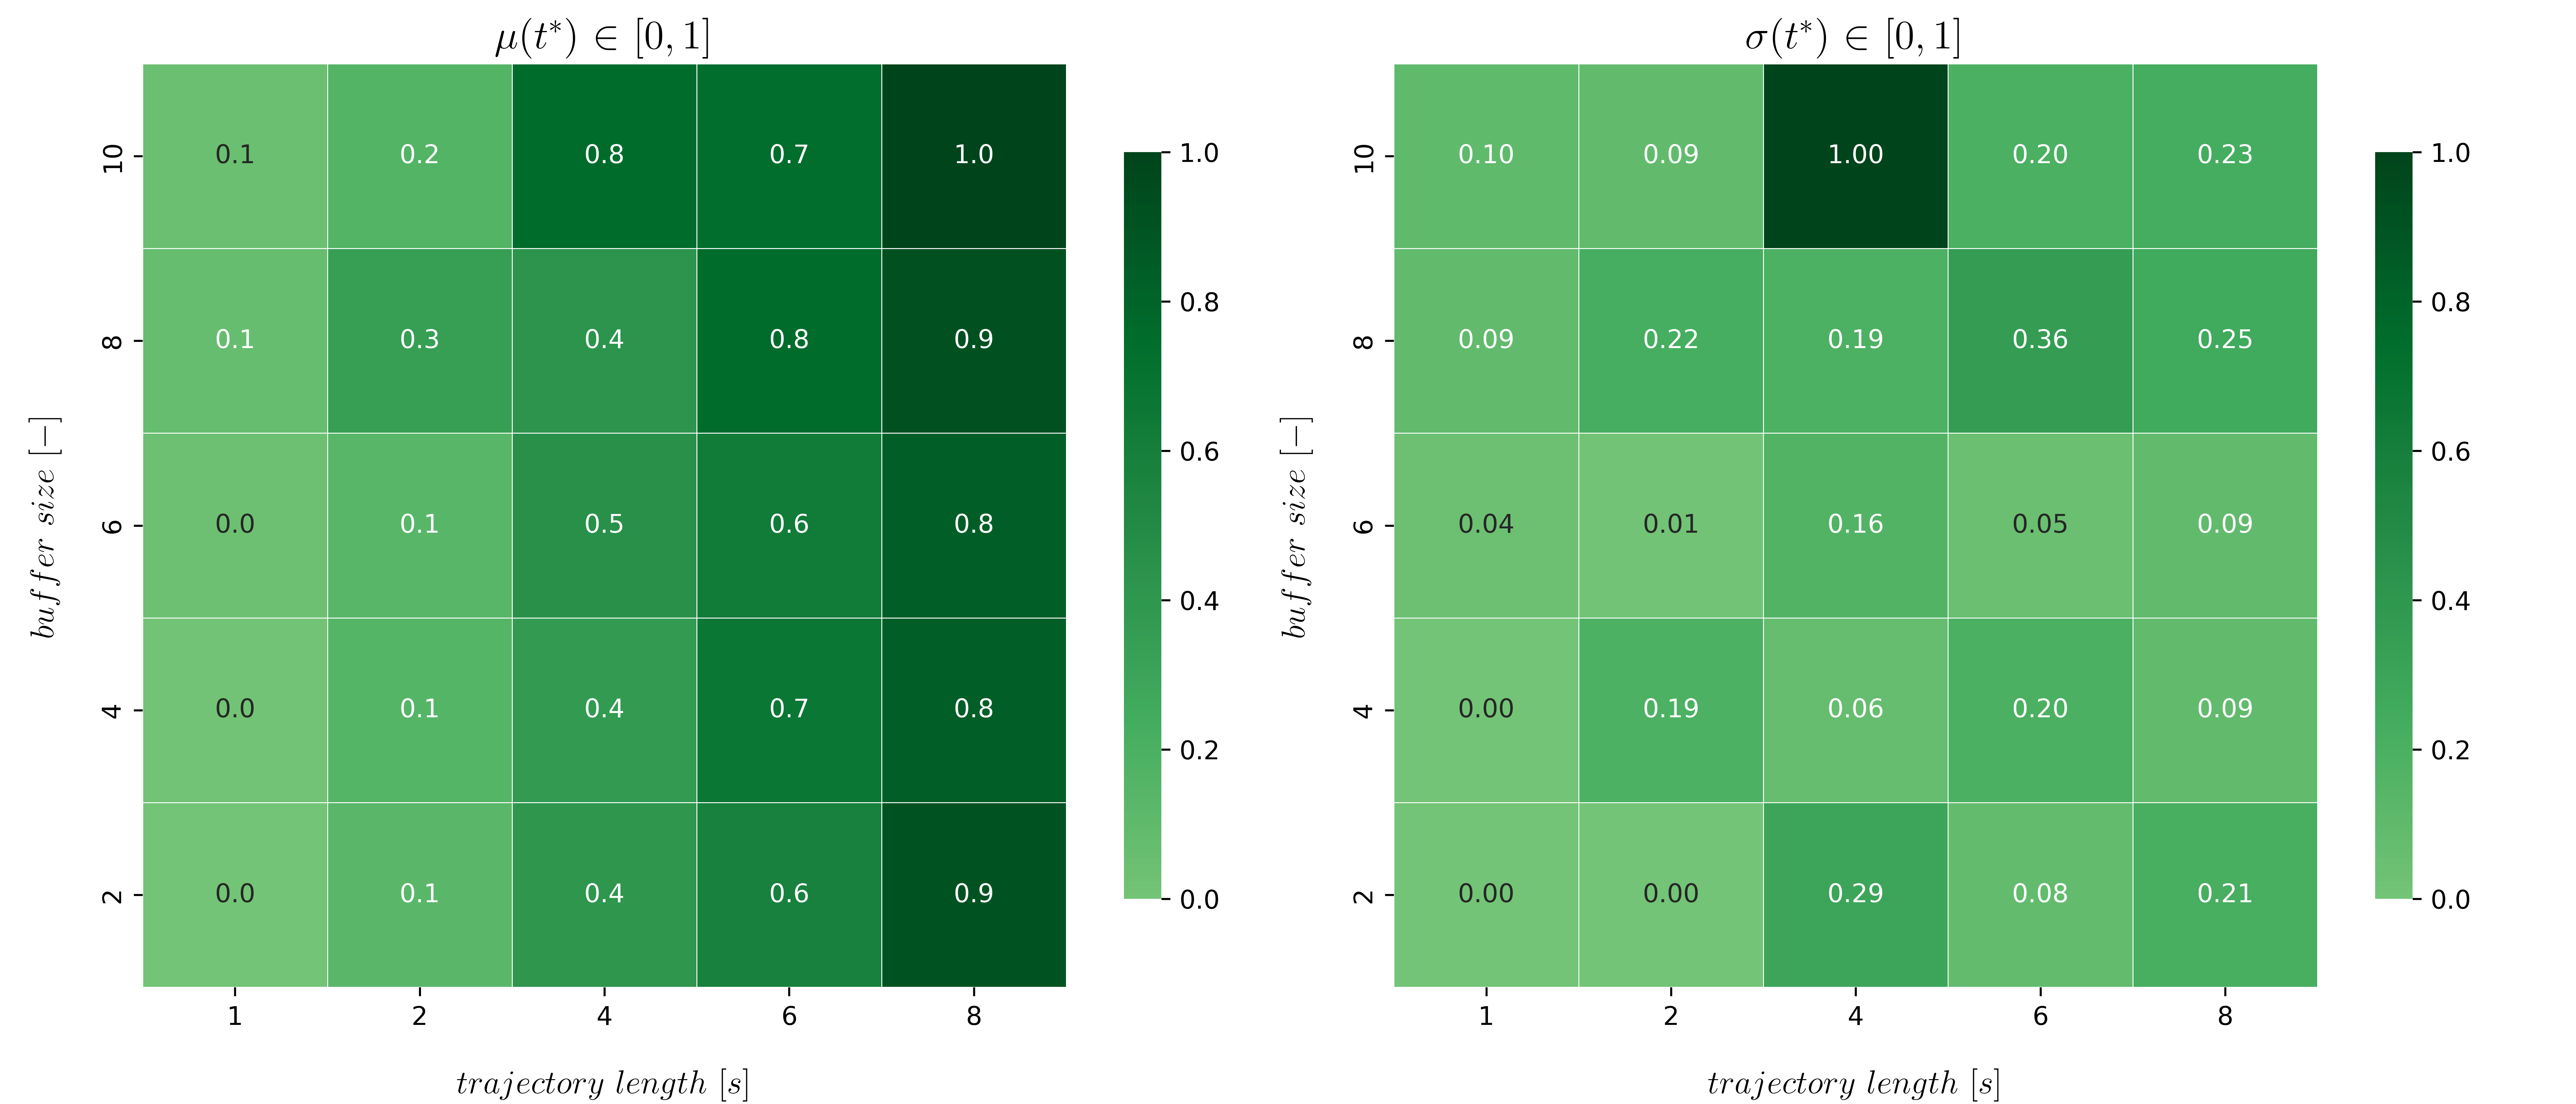

# General remarks about running a training using environment models (MB-DRL)
Trainings using environment models instead of solely relying on CFD simulations may produce significantly different results compared to their MF-counterpart, the following sections aims to give some helpful advice on choosing parameters for a model-based training. In all subsequent plots, episode $e = 0$ and all episodes $e \% 5 = 0$ where performed using the CFD environment, in all other episodes the agent was trained with the environment models. The environment models itself where trained sampling randomly data from the current and the last CFD episode.

# 4. Choosing parameters for a MB-training using the 'env_model_rotating_cylinder.py' script
The 'env_model_rotating_cylinder.py' script provides a rather simple training routine for a MB-training. The performance in terms of rewards and run time is quite well, however, there are some issues regarding the stability of the training itself as well as the implementation. Especially when running on an HPC cluster, trainings tend to crash when increasing the trajectory length and / or number of environment models in the ensemble, as will be explained in the following sections. The implementation of the training routine is not using (any) standard methods, e.g. the torch *dataloader*, also only a fraction of the available training data is used in every epoch instead of the complete training dataset. This makes any further changes within the training routine impossible without re-writing the script. As a consequence, although yielding quite good results, this training routine is not recommended to use; but kept in the repository for the sake of completeness.

## 4.1 Limitations with respect to the trajectory length
The current implementation of the MB-DRL algorithm allows stable trainings up to a trajectory length of $l = 4s$. However, especially when running the training on an HPC the results may differ from trainings run locally up to a point of complete failure, as shown in the next section. The buffer size for a MB-training should at least be $b = 4$ and a minimum trajectory length of $l = 1s$ is required in order to produce meaningful results. An increase of the number of models in the ensemble is always a good idea, since it reduces the uncertainty when predicting the trajectory, leading to a further improve of the performance wrt the achieved rewards throughout the training. The following plot illustrates the influence of number of environment models on the performance, here $N_{models}$ refers to an ensemble containing $N_{models}$ for predicting $c_d$ and another ensemble with $N_{models}$ for predicting $c_l$ and $p_i$, all results were averaged over $3$ different seeds:

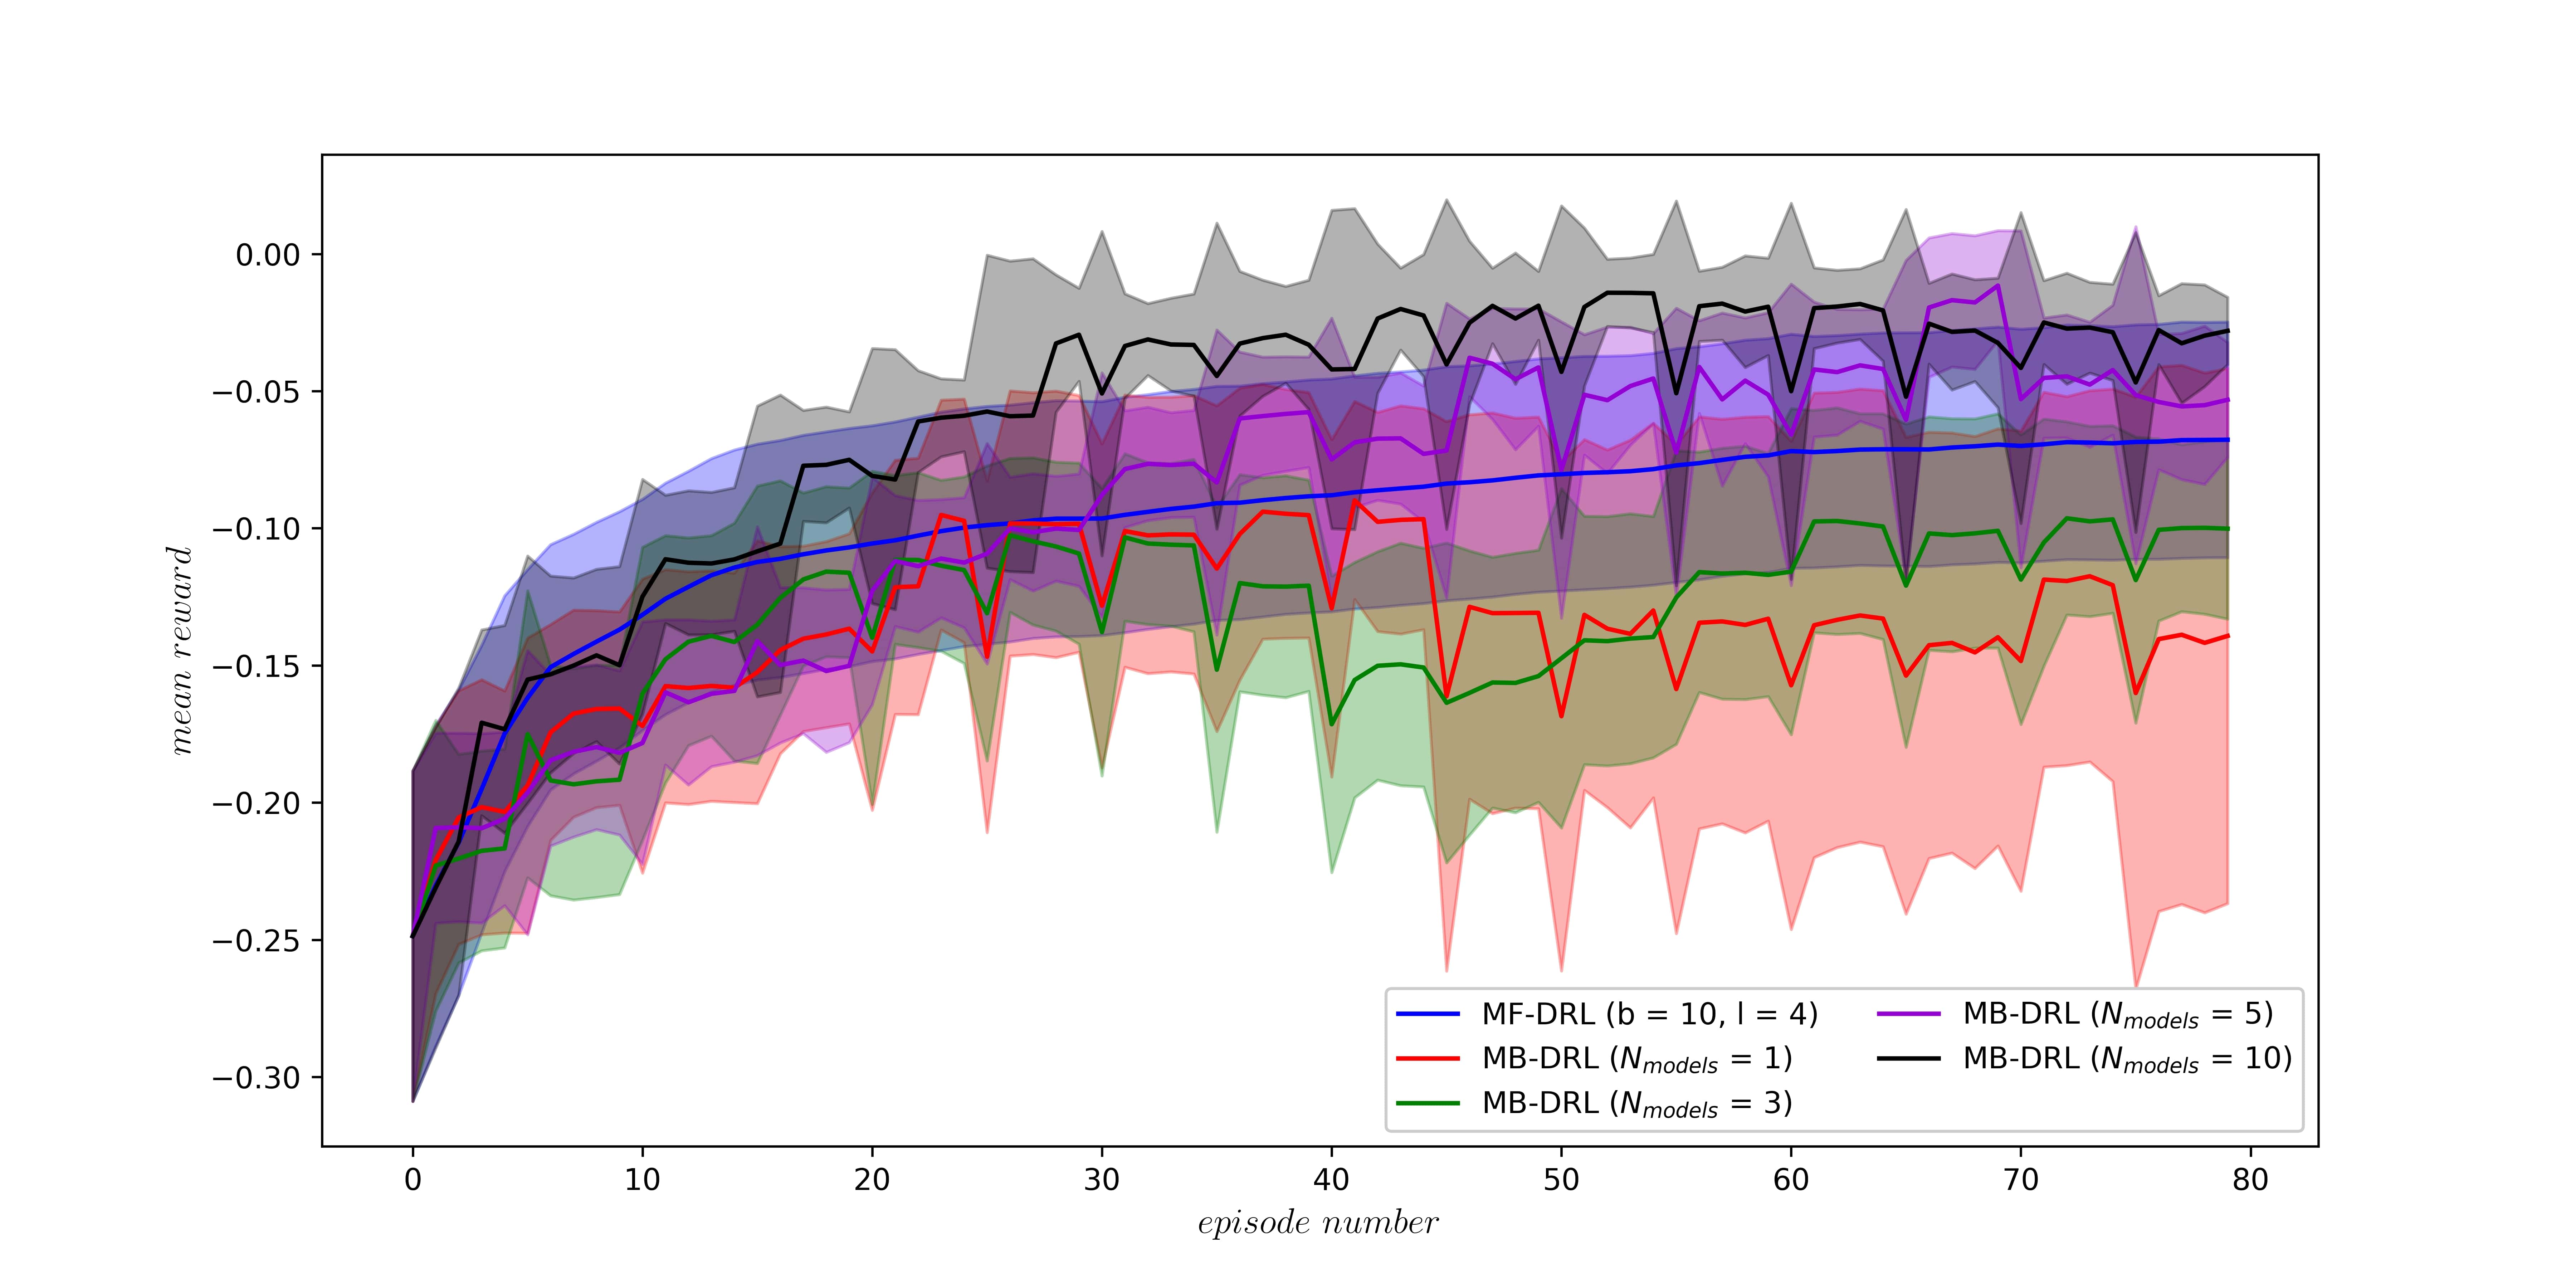

As can be seen in this plot, $N_{models}$ should at least be $N_{models} \ge 5$, but on the other hand, using more than $10$ environment models isn't improving the training much further. Although the environment models are in general too optimistic, the MB-training is able to outperforme the MF-training while at the same time reducing the run time by *73.6%* (on an HPC cluster). For MB-trainings with a trajectory length of $l \gt 4sec$, the training becomes highly unstable and usually crashes at episodes around $e \approx 55...65$ (only tested on an HPC cluster). One possible reason for this behavior is that for $l = 6s$, the environment models need to predict $570$ time steps for each trajectory based on $30$ initial time steps sampled from CFD data. However, model-uncertainties and error propagation often results in unfavorable policy optimization or even invalid trajectories (meaning the values of the MB-generated trajectories are unrealistic / physically impossible) leading to a crash of the CFD simulations and consequently the overall training. In the current implementation, invalid trajecories are generally filtered out, as discussed in the next section.

## 4.2 Differences between running a training on an HPC cluster and on a local machine
Running a training on an HPC may lead to different results compared to a training on a local machine, as mentioned in the previous section. When running a training on an HPC cluster, CFD simulations tend to crash more often leading to less and/or worse training data. This decrease in amount and quality of available training data consequently leads to less accurate environment models and worse performance of the agent. Although this behavior may differ depending on the HPC used as well as the current traffic and available resources on the cluster, it was found that:
- an increase in $N_{models}$ leads to more frequent crashes and worse performance up to a point, where no converged trajectories within the last $3$ CFD episodes could have been generated. In this case, the current implementation of the MB-DRL algorithm aborts the training since the policy can't recover from the lack of this amount of data in the remaining episodes (crashes occur usually in episodes $e = 50...65$). This behavior stands in direct contrast to the behavior observed when running a training on a local machine.
- the longer the trajectories, the more CFD simulations are crashing, this behavior was also not observed on a local machine, however, using long trajectories ($l \gt 4s$) is not recommended in general due to error propagation and model inaccuracies (see previous section)  
- model inaccuracies may lead to invalid trajectories, which are filtered out in the current MB implementation. If there can't be generated any valid trajectories within $50$ iterations (for each trajectory in the buffer) by the environment models, the algorithm switches back to CFD and buffer is filled with trajectories from CFD. The models are then re-trained with this newly generated CFD data. Unfortunately, it can't be prevented to switch back to CFD in the next episode (in case again no valid trajectories can be generated) at the moment, leading to a significant increase in run time. In a worse-case scenario, the training then becomes basically MF, but addionally every episode environment models are trained and (invalid) trajectories are generated, leading to an additional increase of run time. **This issue may also occur when running a training on a local machine, but so far this behavior was only observed when running on an HPC cluster.**

In general, an average MF-training with a buffer size of $b = 8$ and a trajectory length of $l = 2s$ takes around *04h:53min* on an HPC and *23h:19min* on a local machine (both averaged over $3$ seeds and run for $i = 80$ episodes). By using an MB approach, the run time for the same setup can be reduced to *01h:45min* on an HPC and *05h:15min* on a local machine which constitutes a decrease of *-64.16%* and *-76.57%*, respectively. The resulting performance, however, differs for the MB cases as shown in the next plot (all cases have $b = 8,  l = 2s$).

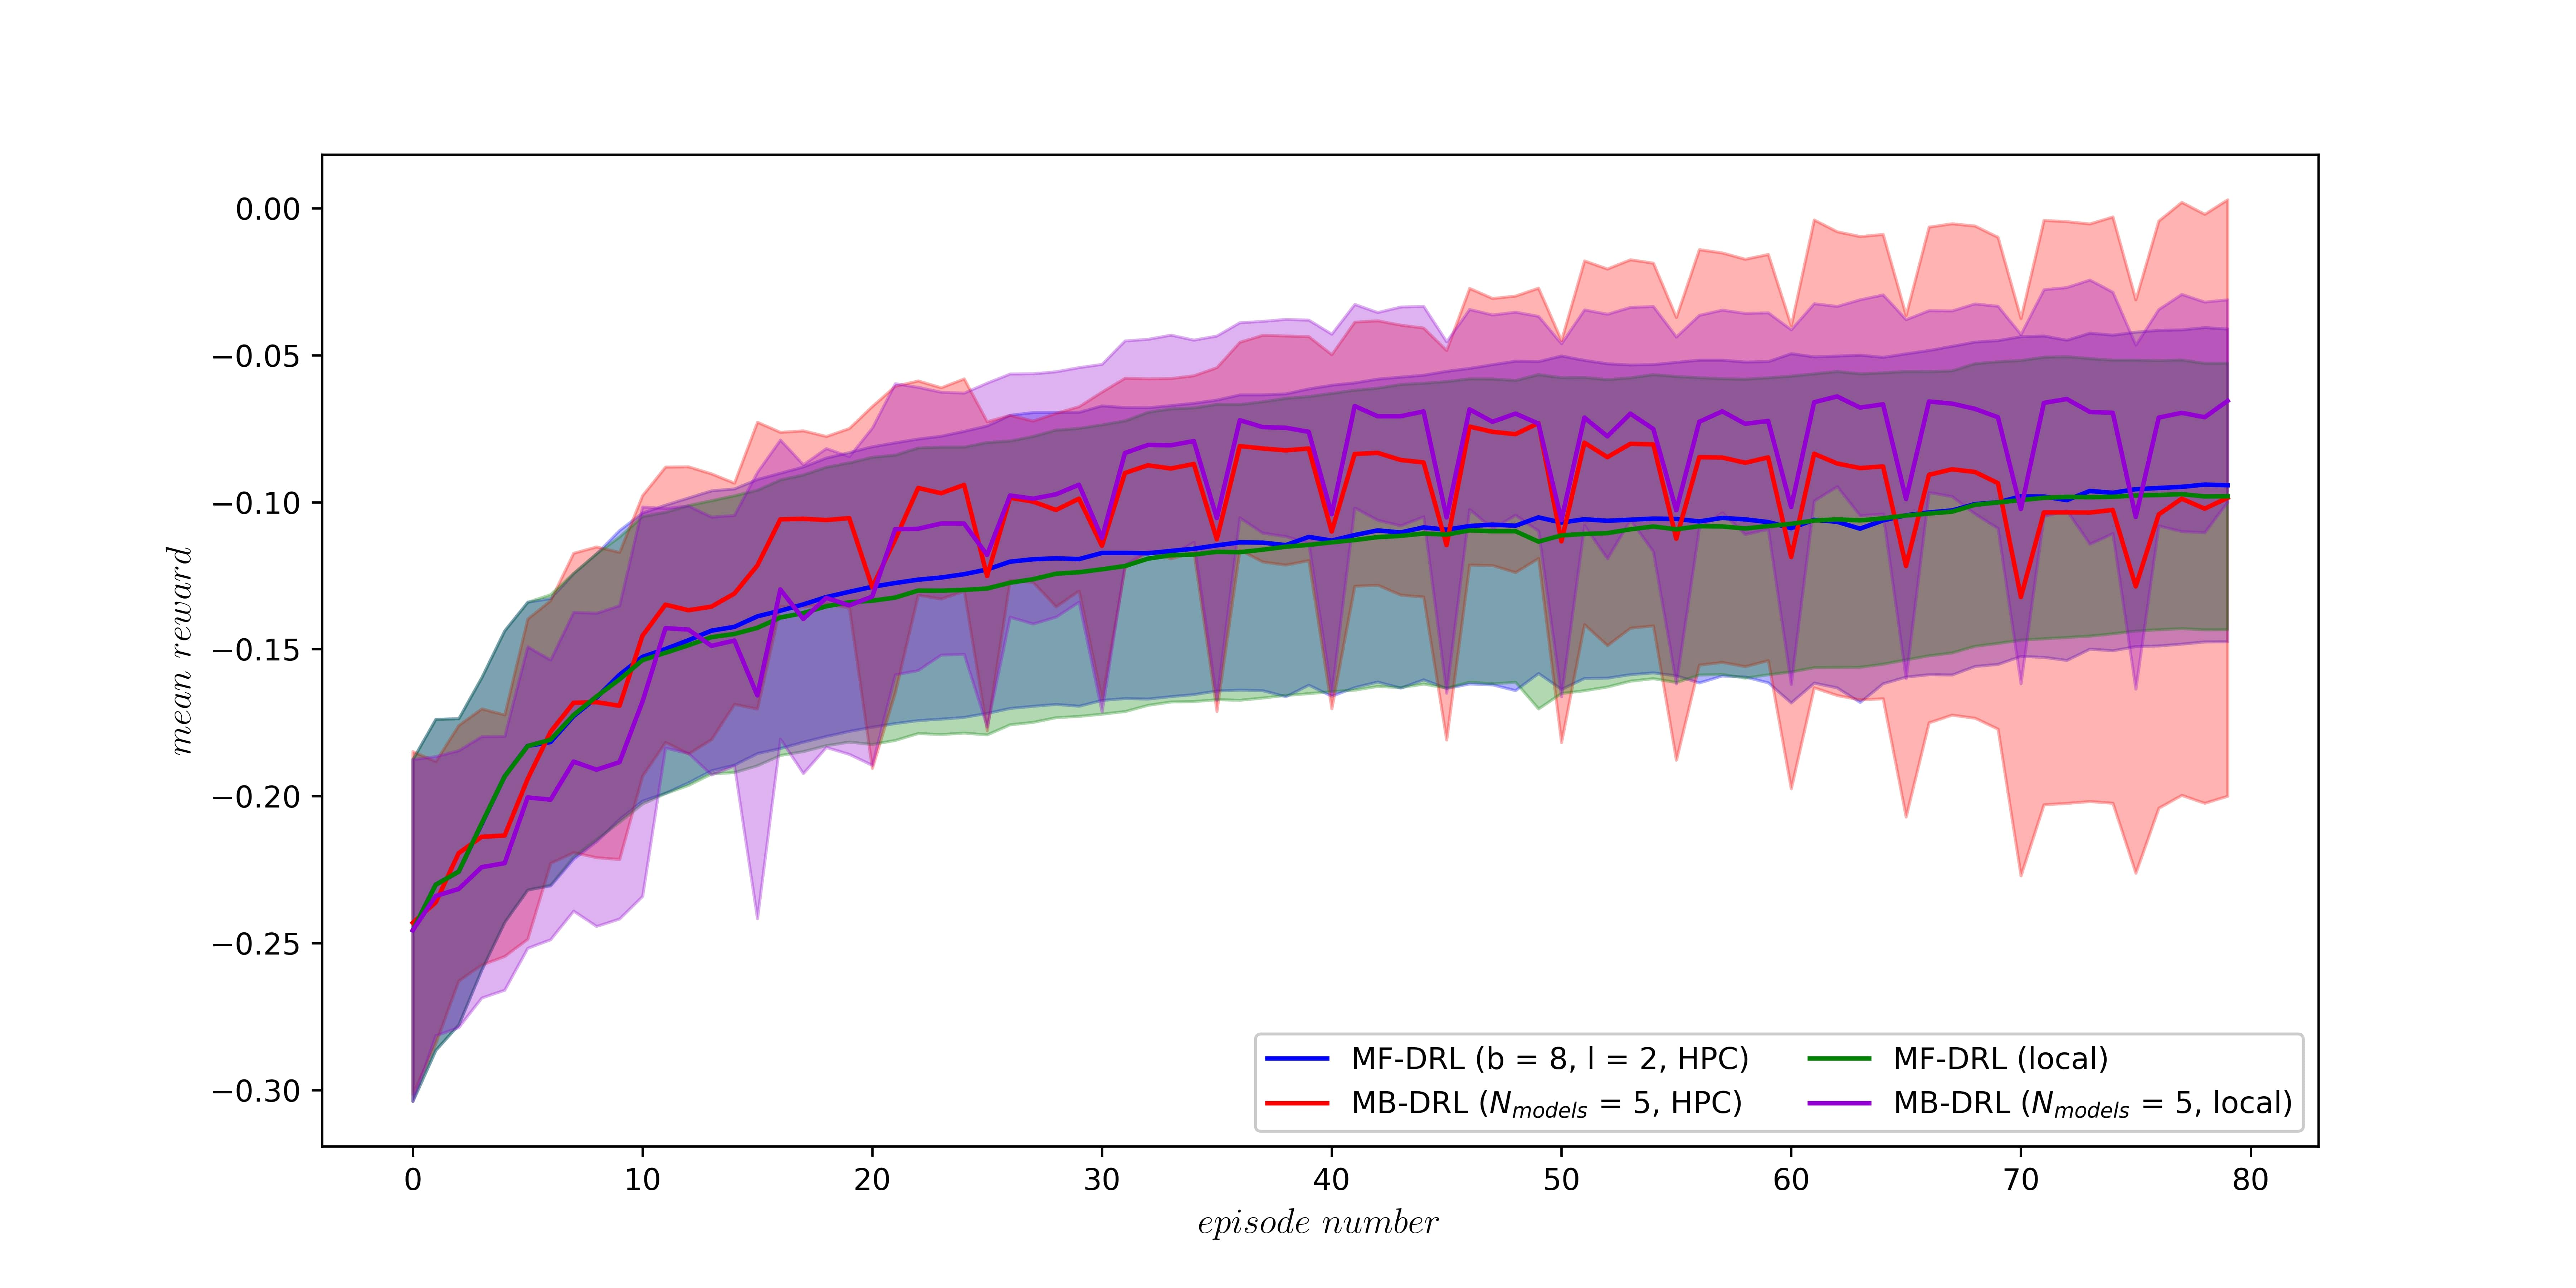

As can be seen, for the MF cases there are no real differences in the overall training process, but due to failed trajectories when running on an HPC the performance for an MB-training is generally worse when using an HPC cluster instead of a local machine. This behavior motivated the implementation of another training routine using stadardized methods, which is loacted in the 'env_model_rotating_cylinder_new_training.py' script and will be presented in the following section.

# 5. Choosing parameters for a MB-training using the 'env_model_rotating_cylinder_new_training.py' script
In comparison to the previous training routine, the new training routine yields the same behavior wrt chosen parameters. The only major difference is generation of the feture-label pairs for training the environment models and the execution of the training routine in general. This training routine runs slightly more stable than the previous one while yielding comparble results. All following plots are averaged over $3$ different seeds.

## 5.1 Influence number of models
As in the previous training routine, here a number of $N_{models} = 5$ seems to yield the best results.

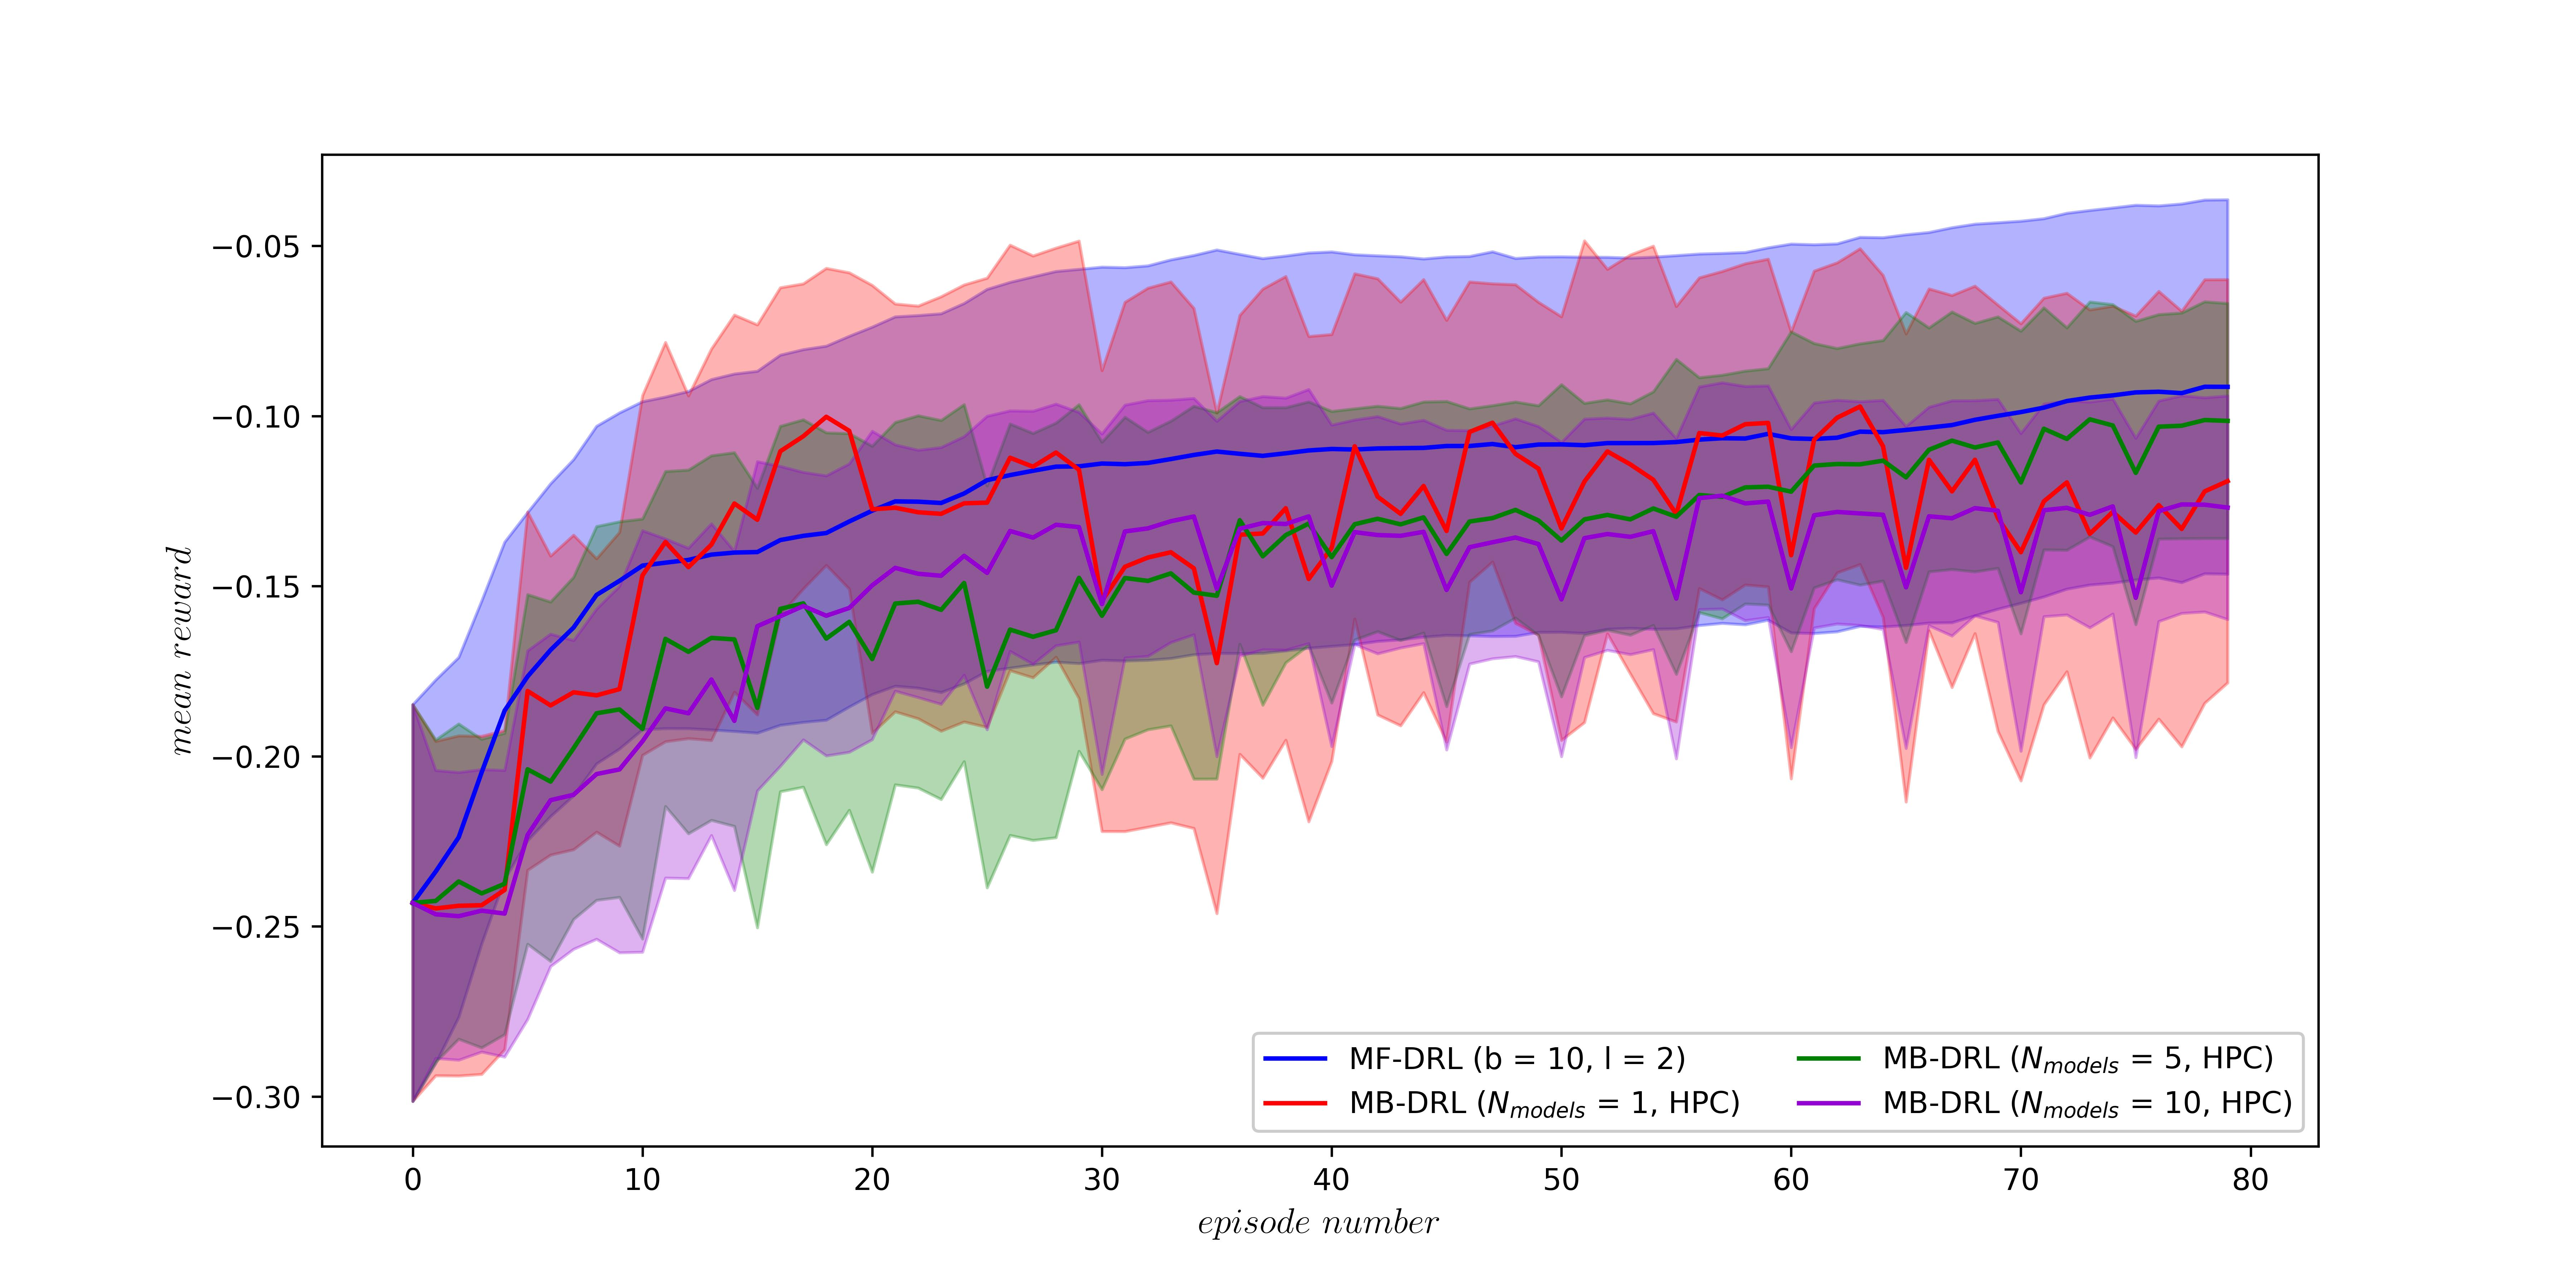


## 5.2 Running a MB-training on different HPC systems
As the previous training routine, the new training routine may yield different results when run on different systems. This is probably caused when processes (e.g. simulations) have to wait too long for execution and are then aborted at some point. This leads to a lack or even the abscence of training data and consequently a deterioration in accuracy of the environment models. Another possibility may be some sort of dependency on the hardware when generating the seed since for the same seed values run on different systems, the results were sometimes different. However, since this behavior couldn't have been reproduced on local machine the following plot shall give an impression of what differences can be expected in a **worst-case scenario**. In other cases, differences within the results were not present or neglectable.

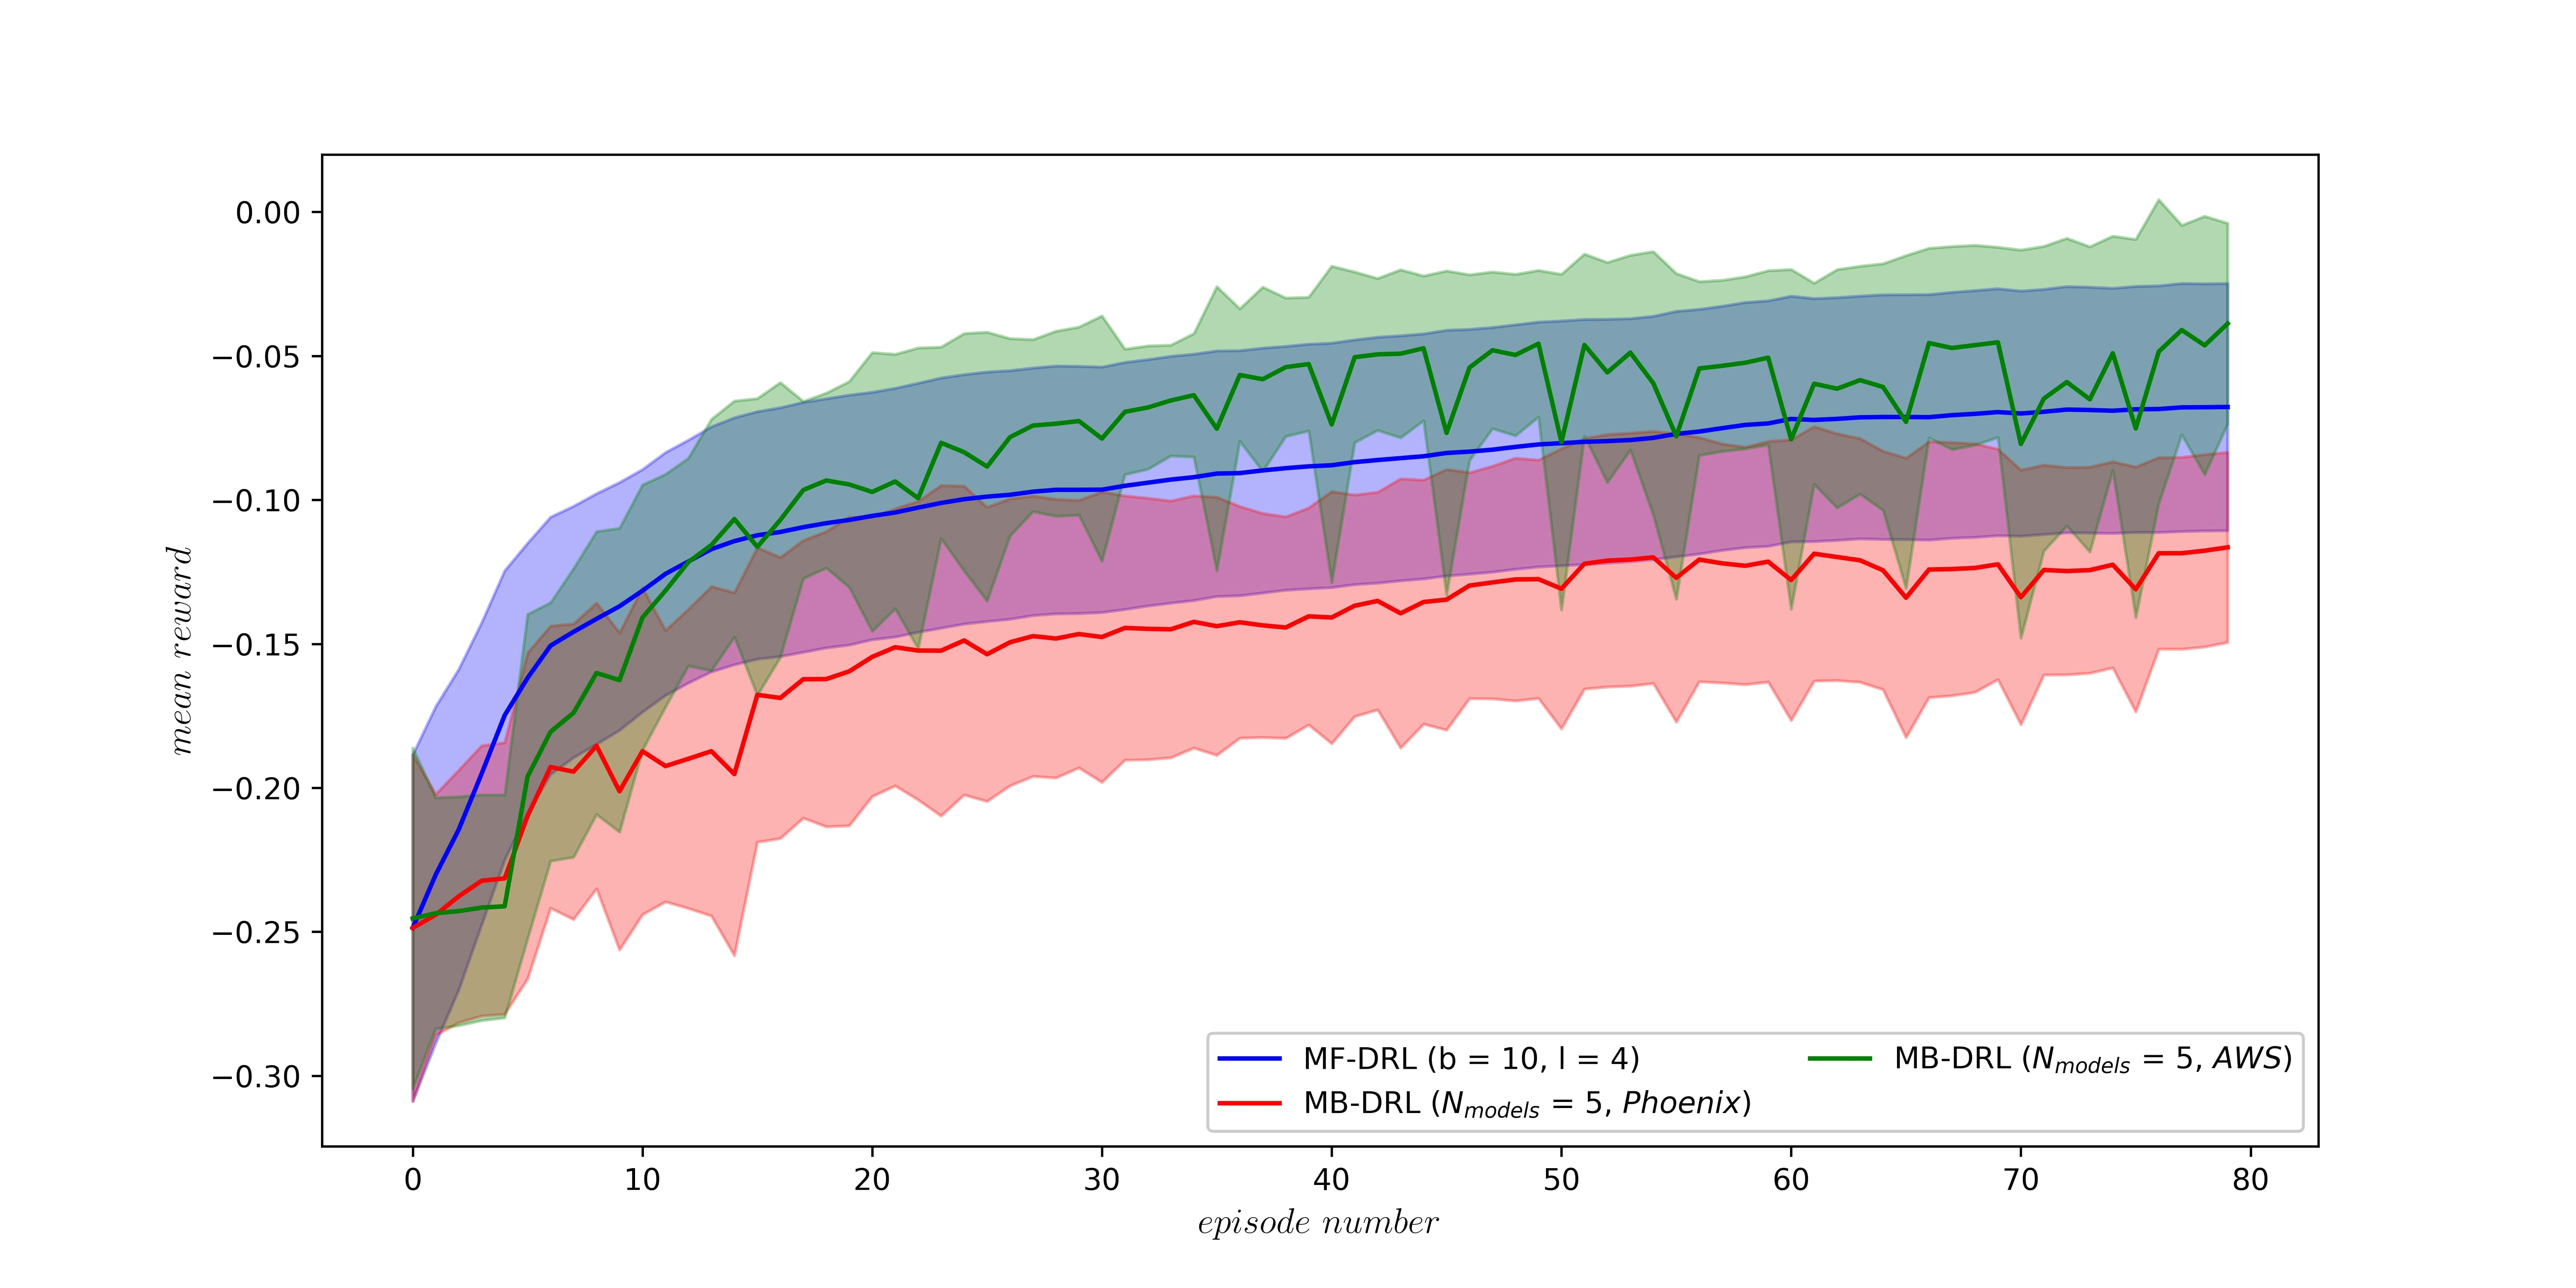

Here, all cases are run with $b = 10, l = 4s$ and averaged over $3$ different seeds. *Phoenix* denotes the HPC of the TU Braunschweig while *AWS* denotes Amazon Web Services.

# 6. Final results for trainings with $Re = 100$
The following plots illustrate the results of a MB-training in comparison to their MF counterpart and the performance of the final policies within the CFD environment at a Reynolds number of $Re = 100$. Some key facts about how these results were obtained:

- all cases $N_{models} = 5$ and all episodes $e == 0$ and $e \%5 == 0$ are run in CFD  
- all cases have $r = b = 10$  
- as mentioned before, the trajectory length $l = f - 4s$ where $f$ denotes the *finish* parameter for executing the training  
- here the results of the last CFD policy (episode $75$ for the MB-cases and episode $80$ for the MF-cases) is taken as policy for benchmarking in the CFD environment   
- the rewards are averaged over $3$ different seeds. For the final policies, the best seed of each case was taken  
- the flow control starts in all cases at $t = 4s$  
- as reference, the run times (avg. over $3$ seeds and run on *AWS* with *10* CPU's in parallel) were:
    - $l = 2s$, MF:    03h:04min  
    - $l = 4s$, MF:    09h:05min  
    - $l = 2s$, MB:    01h:20min   (-56.36% compared to MF counterpart)  
    - $l = 4s$, MB:    02h:49min   (-68.91% compared to MF counterpart) 
    
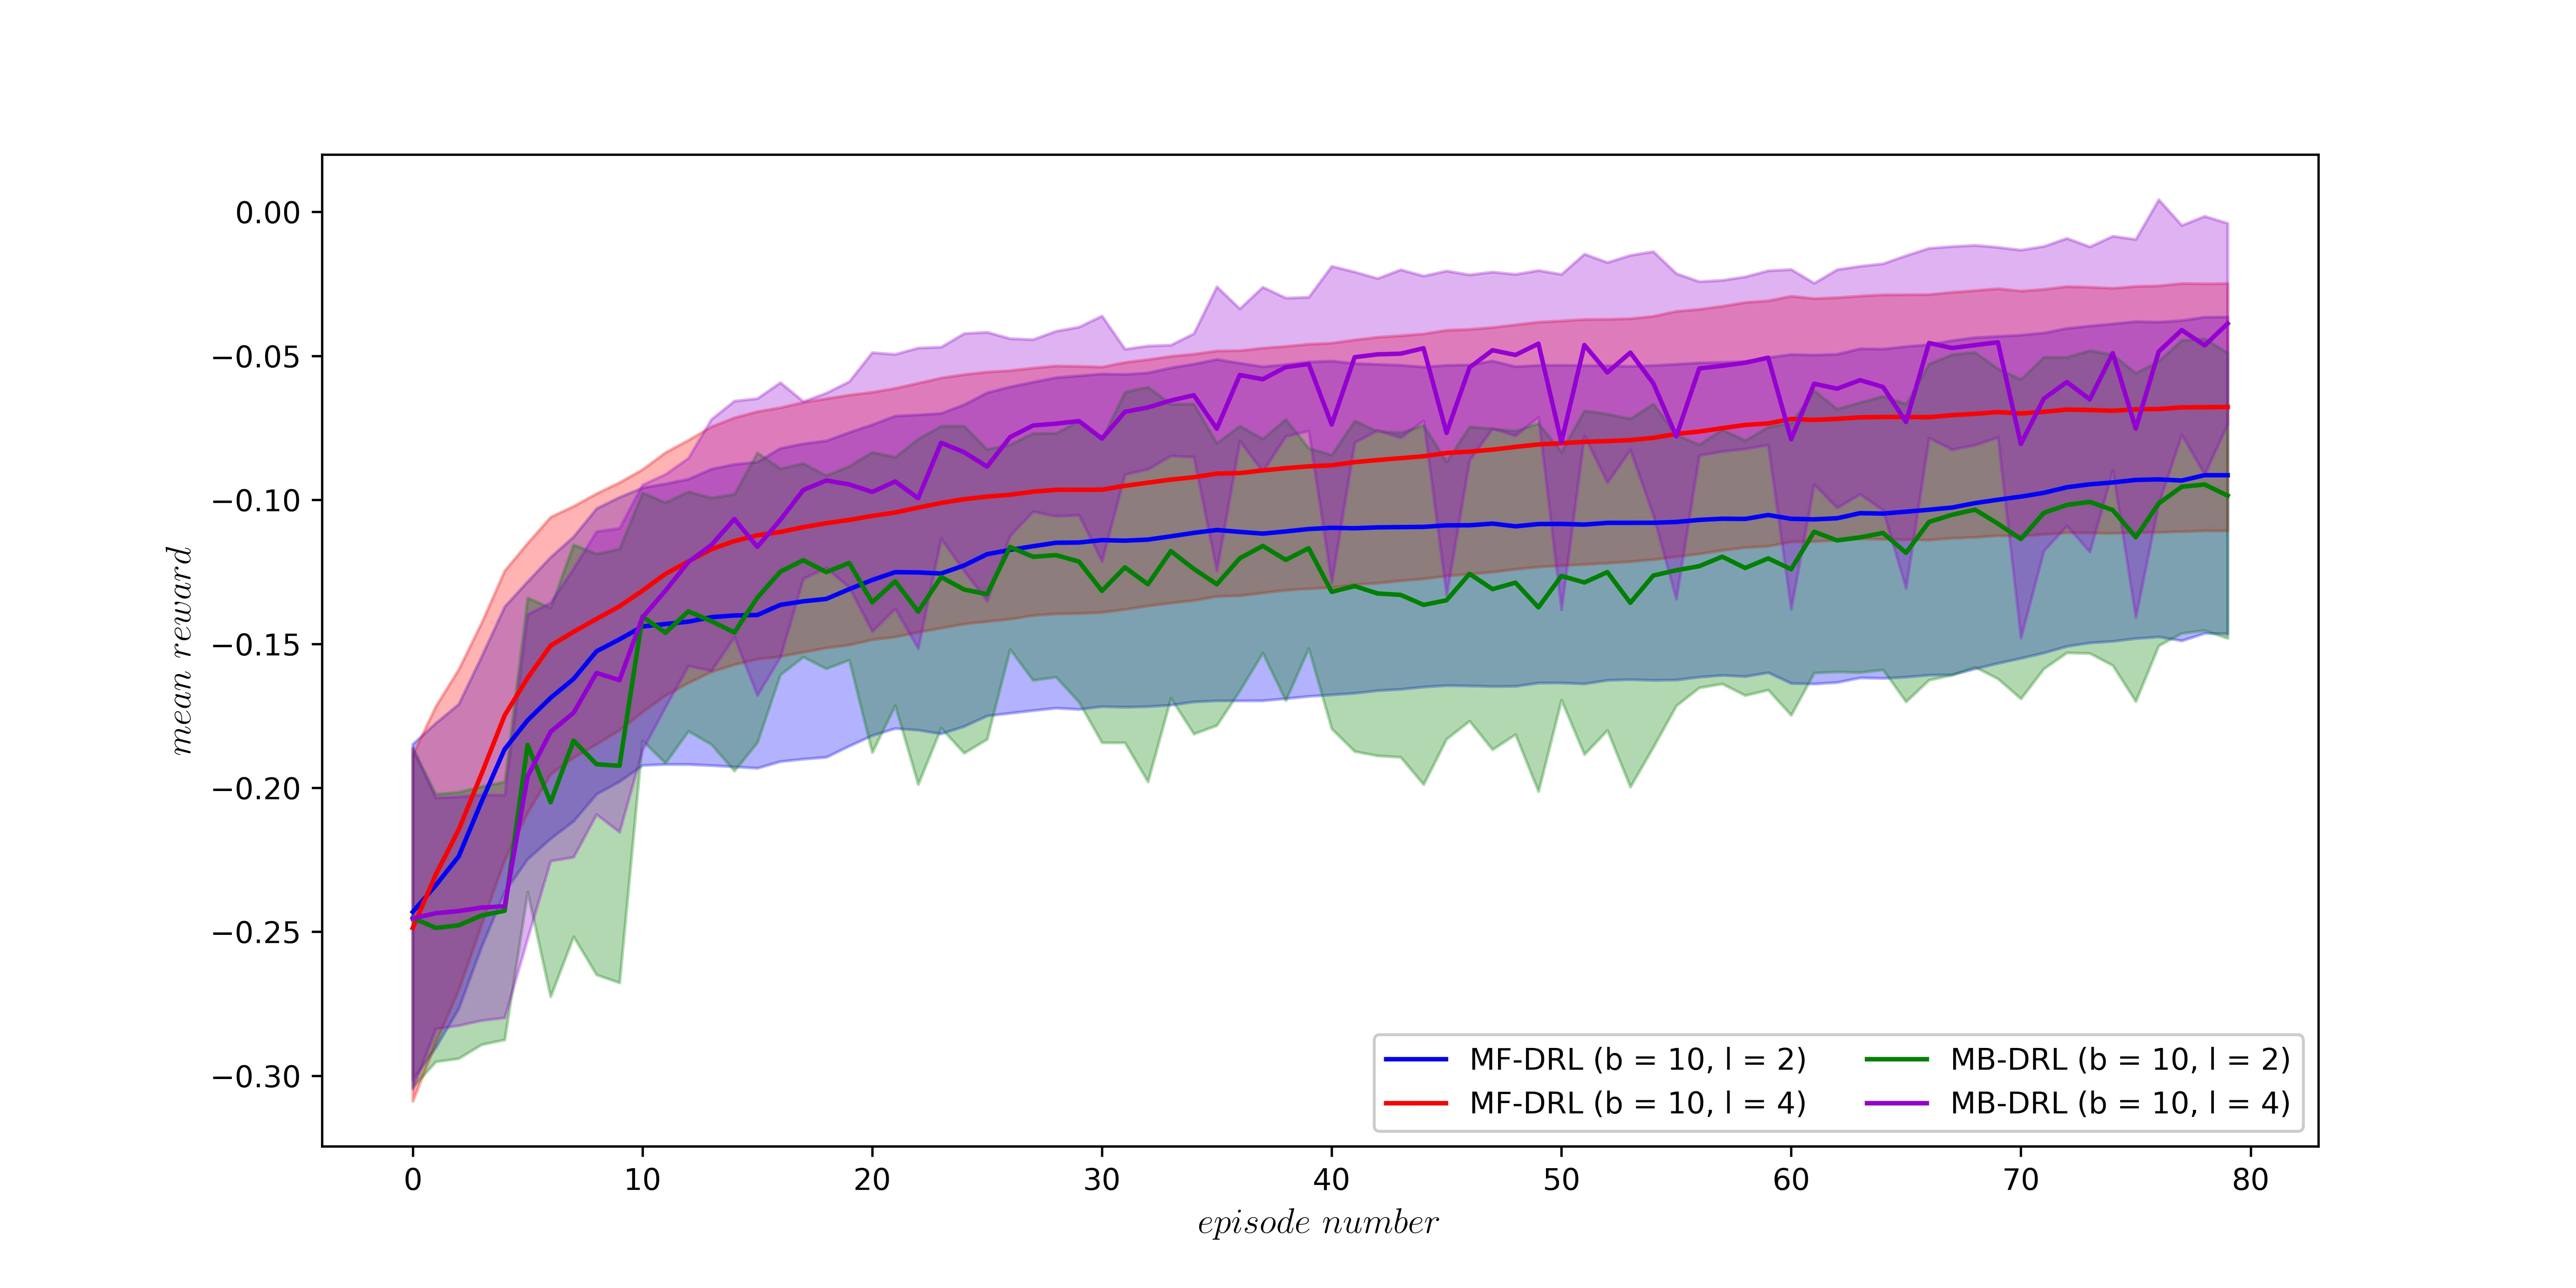

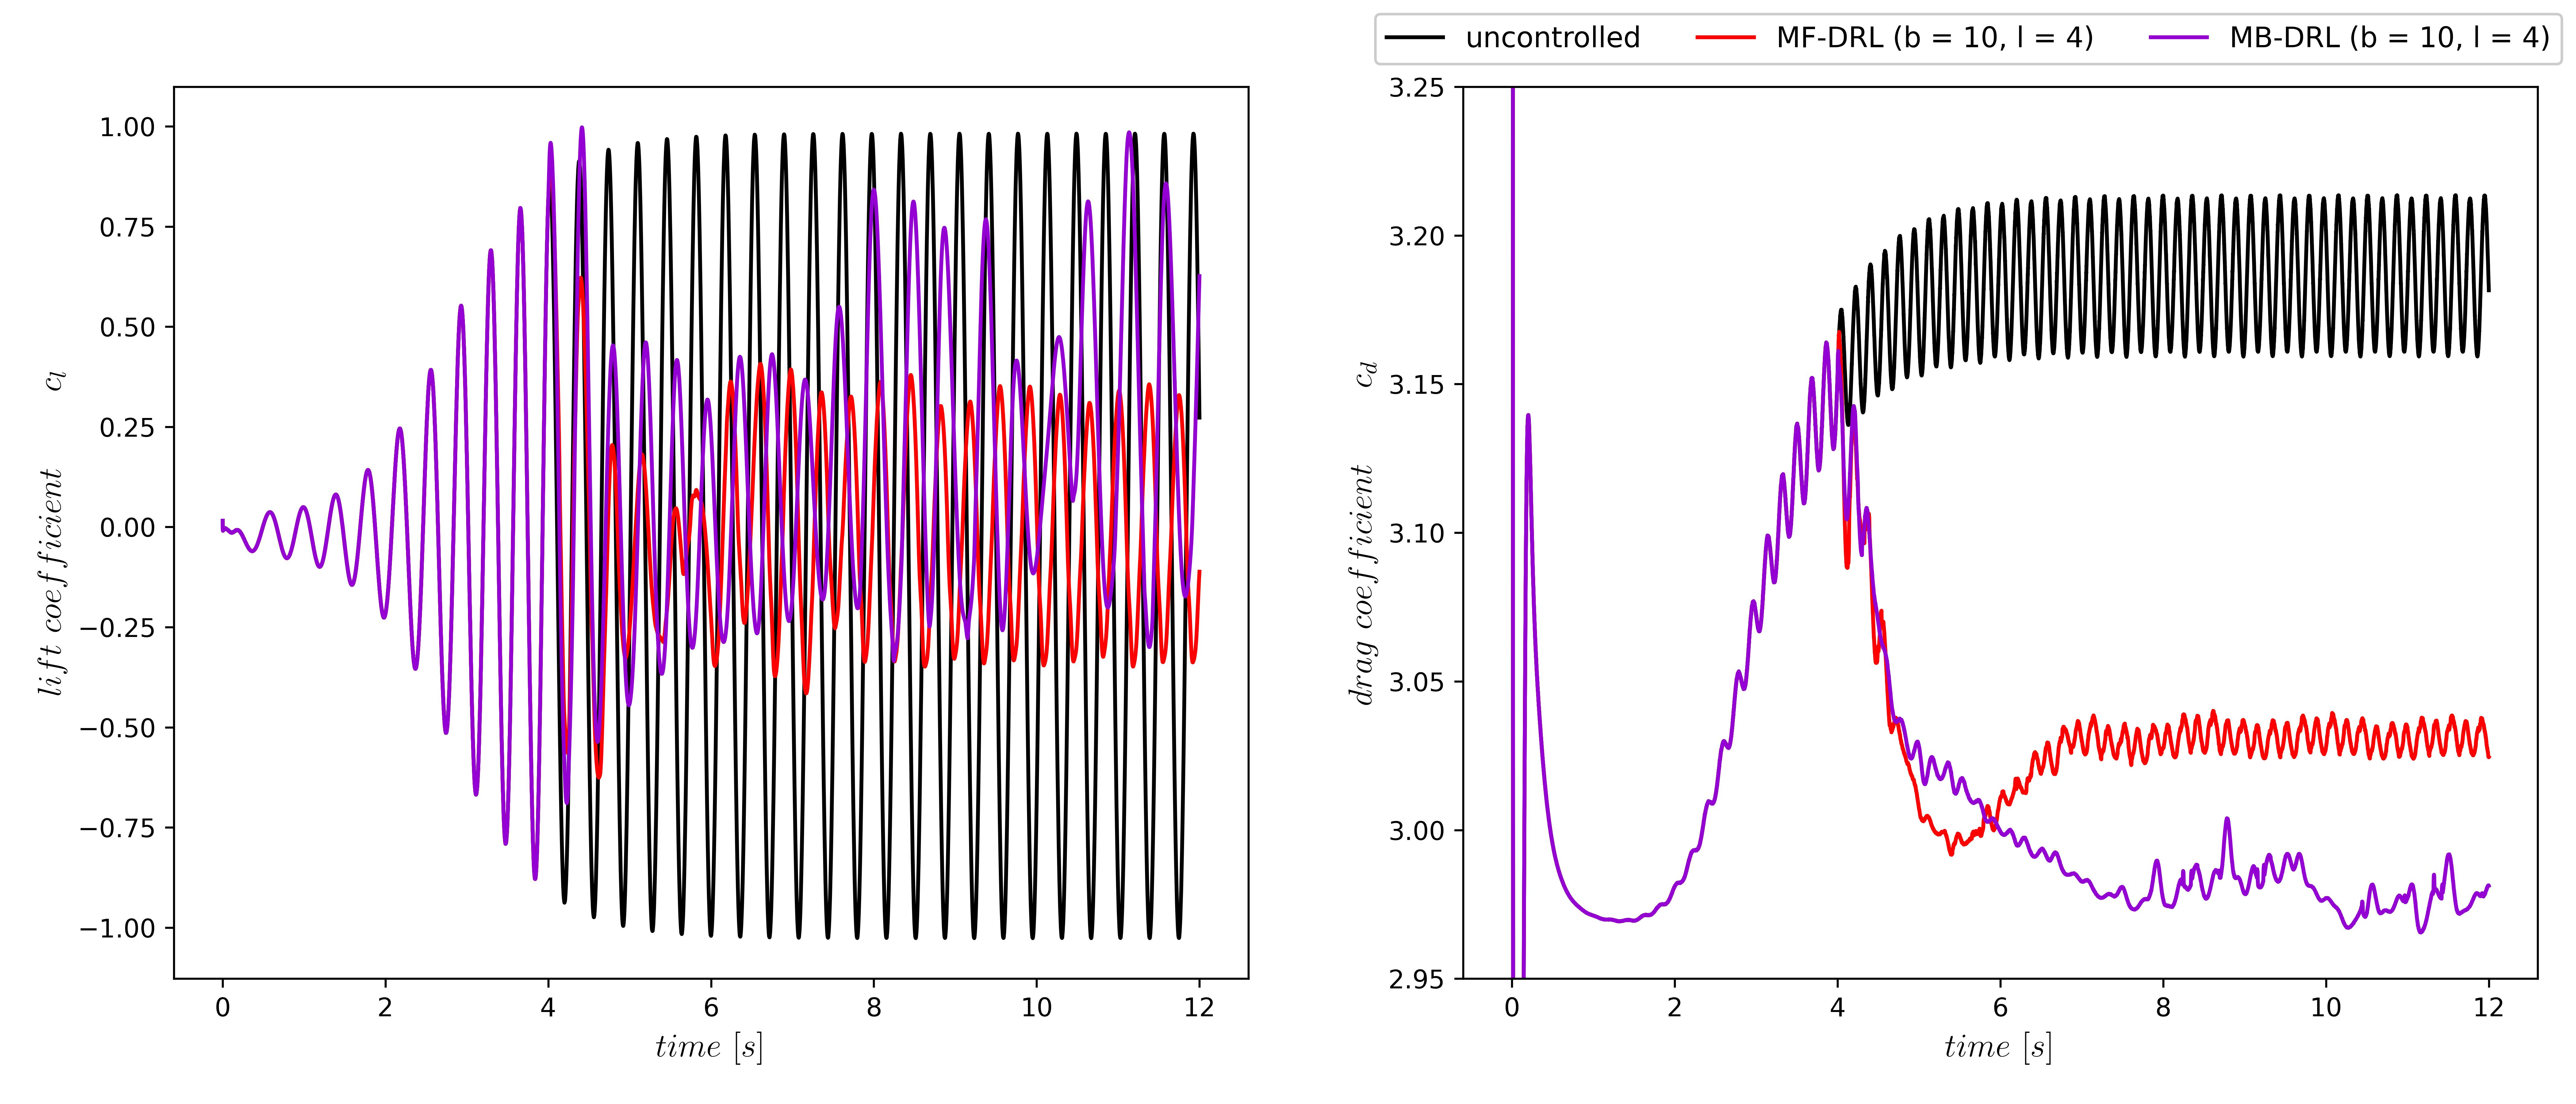

# 7. Final results for trainings with $Re = 2000$

same training routine as in $Re = 100$ section


# 8. Concluding remarks
This section summarises the most important key facts for running an MB-training. This list is by no means comprehensive, for more detailed information feel free to check out the report.

- the 'env_model_rotating_cylinder_new_training.py' yields a more stable and generalized training process than the 'env_model_rotating_cylinder.py' and is therefore better to use   
- the stability of the training and the results in general highly depend on the seed value  
- especially for longer trajectories it may happen that there are no CFD trajectories available over the last $3$ CFD episodes due to an unfavorable policy. In these cases, the training is aborted  
- depending on the system (local / HPC, ...) and the current traffic (HPC), CFD trajectories tend to crash more often if processes have to wait. In these cases, the training sometimes crashes with the error message `RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated` in the *update* method of the *ppo_agent.py*; probably caused by faulty CFD trajectories. Since it was not possible to reproduce this error on a local machine, it is best to just re-start the training with another seed value   
- the correction of MB-trajectories with additional models is not really working, so for now it is best to leave *corr_traj = False* in *run_training.py*. But for the sake of completeness and maybe as a starting point for other methods / ideas in the future it is left in the script  
- an increase in $N_{probes}$ yields worse rewards, especially for longer trajectories ($l = 4$), but in some cases it may improve the stability of the training  
- the same applies for using the *EnvModel* class instead of the *FCModel* class for the environment models. It is therefore currently deactivated as well but can be uncommented in the *train_env_models* function of the *env_model_rotating_cylinder_new_training_routine.py* script. Maybe an optimization of the model architecture can improve the results in the future  
- it was found that for short trajectories, e.g. $l = 2$, switching every episode $e \% 5 == 0$ back to CFD yielded the best results. However, for longer trajectories, e.g. $l = 4$, a shorter distance between two CFD episodes, e.g. $e \% 2 == 0$ improves the results (but of course increases the run times)  
- $N_{models} = 1...5$ yielded in all cases (sometimes by far) the best results. $N_{models} = 1$ was found to run more unstable than $N_{models} = 3...5$. An increase of $N_{models}$ to let's say $10$ or more destabilizes the training as well up to a point of complete failure (depends also on the trajectory length)    
- for the MB-training, a buffer size of $b \ge 4$ is required in order to have enough training data for the models available. This contraint shouldn't have much of a negative effect on the usability of the training routine, because for a buffer size of $b < 4$ the results for a MF-training are quite bad in general, so even for MF-Training, $b \ge 4$ should be chosen  
- despite the training method and chosen parameters, it is not recommended to use an MB-training for trajectories $l > 4s$. When increasing the trajectory length to e.g. $l = 6$, a significant amount of trainings crash throughout the training, and even if the training is not crashing, it is unlikely to yield a good result    
- **the model-generated trajectories are checked for invalid values, the boundaries in which a trajectory is seen as valid can be modified in the *check_trajectories* function of the 'env_model_rotating_cylinder_new_training.py' script, since they depend e.g. on the Reynodels number etc.**. An indicator of unfavorable chosen boundaries is the unusually often dicard of model-generated trajectories and when the training is constantly switching back to CFD after $50$ trials of generating trajectories  

Conclusively, it can be said that if there is an HPC or similar computational resources available, and the run times are not a major concern, then using a MF-training yields (in most cases) better / similar performance and stablility throughout the training process at the moment. On the other hand, if only a local machine is available (computational resources as limiting factor), or run times are from higher importance than stability, a MB-training may be the method of choice.

If the CFD part of the training is more complex (e.g. more grid points / higher Reynodls number, ...), than an MB-training may save resources / run time, if only every $3^{rd}$ or every other episode is run in CFD. The stability and rewards should then more or less be comparable to the MF-training (depending on the setup). (still TODO, Re = 2000)

Due to the dependency on initialization / seed value and the system (local, HPC, ...), the here shown results may be not entirely reproducable quantitatively, but the overall trend should match (compare section 5.2). In general, there is always a compromise between stability and performance of the MB-training.